### This is a demonstration of aliasing on brain images using slicing.

#### Updated 20180519

When images are downsampled, any frequency components present in the original image about the downsampled Nyquist frequence gets aliased into the lower frequences. Therefore, images are often processed with an anti-aliasing filter that removes frequency components above the new Nyquist frequency. This anti-aliasing filter can be constructed using many existing filter design methods. 

When an image in numpy array is subsampled using slicing:

```
new_img = img[::2, ::2]
```

then this can suffer from aliasing issues. When an image needs slicing is dependent on how the image was sampled. For example, in an EPI-volume, o

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import nibabel as nb

# Part 1: Brain slice example 
    
## (scroll to Part 2)

In [2]:
img = nb.load('T1.nii.gz')

In [3]:
data = img.get_data()
data.shape

(176, 256, 256)

In [4]:
slice = data[78, :, :]
slice_f = np.fft.fft2(slice)

Let's plot the frequency domain representation of this image. We are plotting on a log-scale to highlight image features.

/software/miniconda3/envs/aliasing/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


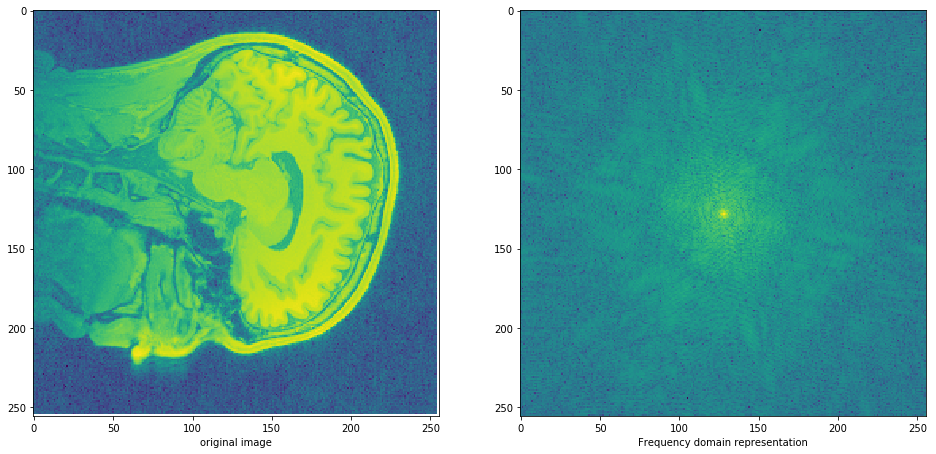

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(np.log10(slice), interpolation='nearest')
ax[0].set_xlabel('original image')
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(slice_f))), interpolation='nearest')
ax[1].set_xlabel('Frequency domain representation');

Now we can remove the central chunk (the low frequency components if we were downsampling by 2) and look at what information is contained in the remaining higher frequency bands.

/software/miniconda3/envs/aliasing/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


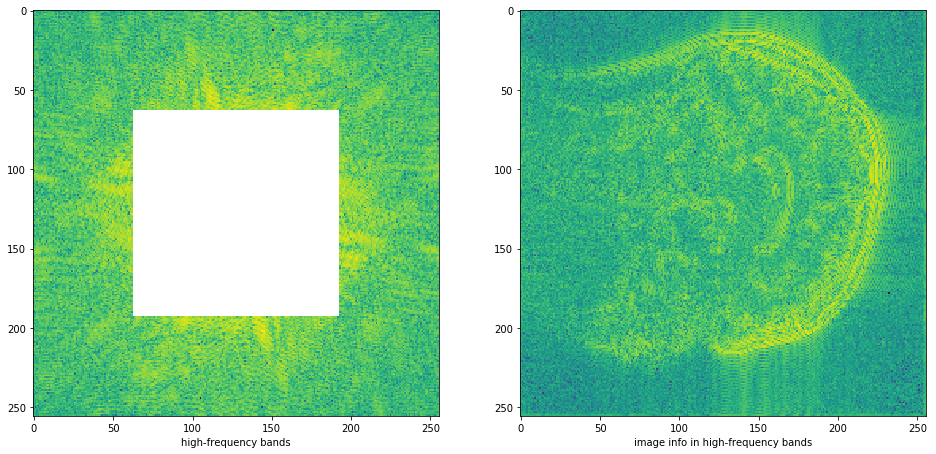

In [6]:
slice_f_inner = np.fft.fftshift(slice_f)
slice_f_inner[63:193, 63:193] = 0
slice_highfreq = np.abs(np.fft.ifft2(np.fft.fftshift(slice_f_inner)))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(np.log10(np.abs(slice_f_inner)), interpolation='nearest')
ax[0].set_xlabel('high-frequency bands')
ax[1].imshow(np.log10(slice_highfreq), interpolation='nearest')
ax[1].set_xlabel('image info in high-frequency bands');

Use a very coarse anti-aliasing filter by removing the outer chunk of the frequency representation.

In [7]:
slice_sub2 = slice[::2, ::2]
slice_f_outer = np.fft.fftshift(slice_f)
slice_f_outer[0:70, :] = 0
slice_f_outer[186:, :] = 0
slice_f_outer[:, 0:70] = 0
slice_f_outer[:, 186:] = 0
slice_antialiased = np.abs(np.fft.ifft2(np.fft.fftshift(slice_f_outer)))
slice_aa_sub2 = slice_antialiased[::2, ::2] 

/software/miniconda3/envs/aliasing/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


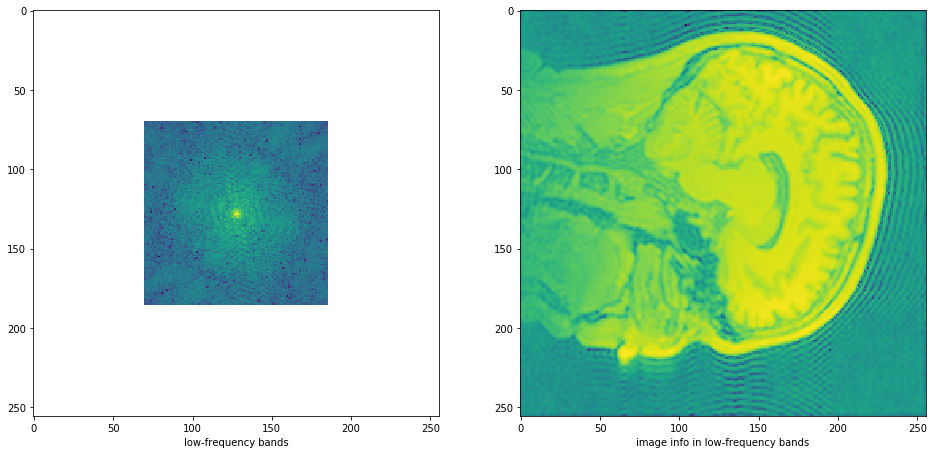

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(np.log10(np.abs(slice_f_outer)), interpolation='nearest')
ax[0].set_xlabel('low-frequency bands')
ax[1].imshow(np.log10(slice_antialiased), interpolation='nearest')
ax[1].set_xlabel('image info in low-frequency bands');

Now plot the sliced images (half resolution)

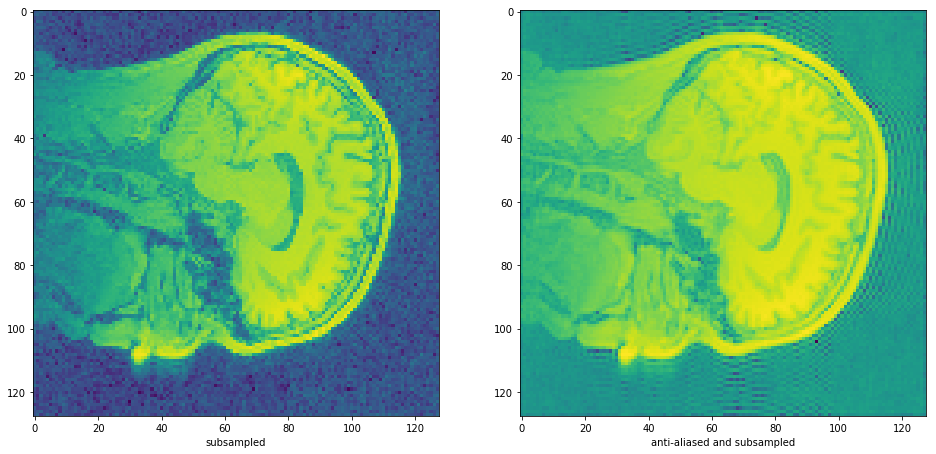

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(np.log10(slice_sub2), interpolation='nearest')
ax[0].set_xlabel('subsampled')
ax[1].imshow(np.log10(slice_aa_sub2), interpolation='nearest')
ax[1].set_xlabel('anti-aliased and subsampled');

Now use some resampling routines from `scipy.signal`.

In [10]:
from scipy.signal import decimate, resample

/software/miniconda3/envs/aliasing/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/software/miniconda3/envs/aliasing/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


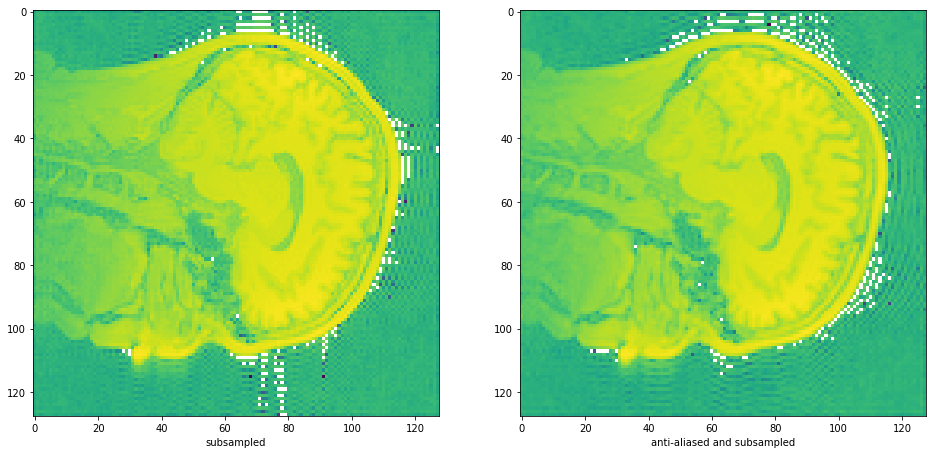

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
#ax[0].imshow(np.log10(slice_sub2), interpolation='nearest')
ax[0].imshow(np.log10(resample(resample(slice, 128, axis=0), 128, axis=1)), interpolation='nearest')
ax[0].set_xlabel('subsampled')
ax[1].imshow(np.log10(decimate(decimate(slice, 2, 30, axis=0, zero_phase=True), 2, 30, axis=1, zero_phase=True)), interpolation='nearest')
ax[1].set_xlabel('anti-aliased and subsampled');

# Part 2: Fresnel zone plate example

    
## thanks: Chris Rorden

When downsampling images, we need to be careful regarding aliasing effects
This demo generates an example stimuli and downsamples it using different methods

A popular solution is from Schumacher, Dale A., Optimization of Bitmap Scaling Operations, p. 17-19, code: p. 425-428,
  
  http://www.realtimerendering.com/resources/GraphicsGems/gems.html#gemsiii

In [12]:
#Create Fresnel Zone Plate
#https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/35961/versions/2/previews/imzoneplate.m/index.html?access_key=
# Practical Handbook on Image Processing for Scientific Applications, by Bernd Jahne, CRC Press, 1997. See equation 10.63
import cv2
np.linspace(-128, 128)
v = np.linspace(-128, 128, 257)
[x,y] = np.meshgrid(v,v);
r = np.hypot(x,y);
km = 0.8*np.pi;
rm = 200;
w = rm/10;
term1 = np.sin( (km * np.square(r)) / (2 * rm) );
term2 = 0.5*np.tanh((rm - r)/w) + 0.5;
g = np.multiply(term1, term2);
g = (g + 1) * 127.5

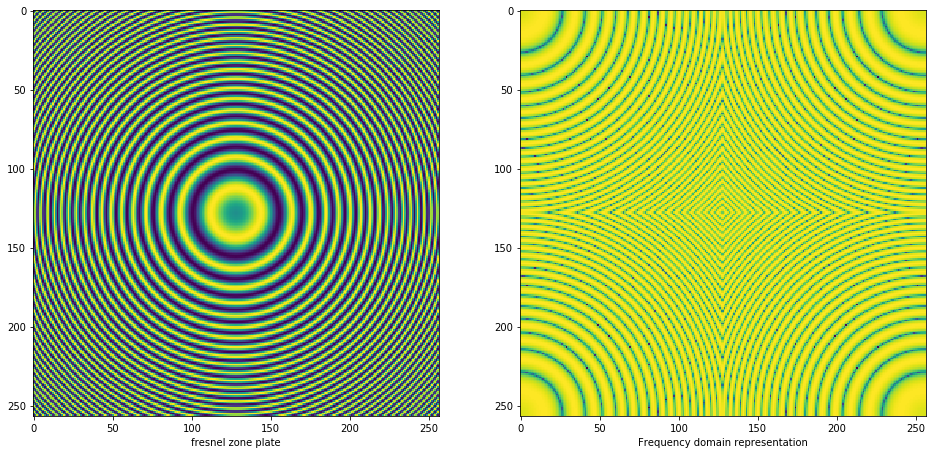

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(g, interpolation='nearest')
ax[0].set_xlabel('fresnel zone plate')
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(g))), interpolation='nearest')
ax[1].set_xlabel('Frequency domain representation');

In [16]:
# note that cv2's anti-aliasing is not very effective
noAA = cv2.resize(g, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
AA = cv2.resize(g, dsize=(64,64), interpolation=cv2.INTER_AREA)

#Naive nearest-neighbor decimation creates aliasing 
res = g[::4, ::4]

#SciPy example 
# be aware that imresize requires a specific version of Pillow
# pip3 install Pillow==4.3.0
import scipy
from scipy.misc import imresize
out = scipy.misc.imresize(g, [64,64], 'bilinear')

/software/miniconda3/envs/aliasing/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


### Cubic interpolation

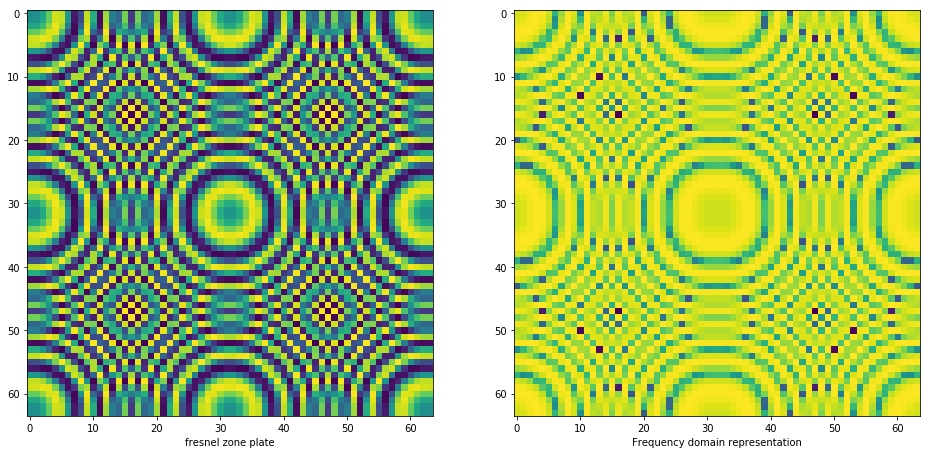

In [17]:
img = noAA
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img, interpolation='nearest')
ax[0].set_xlabel('fresnel zone plate')
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(img))), interpolation='nearest')
ax[1].set_xlabel('Frequency domain representation');

### Area interpolation (Open CV)

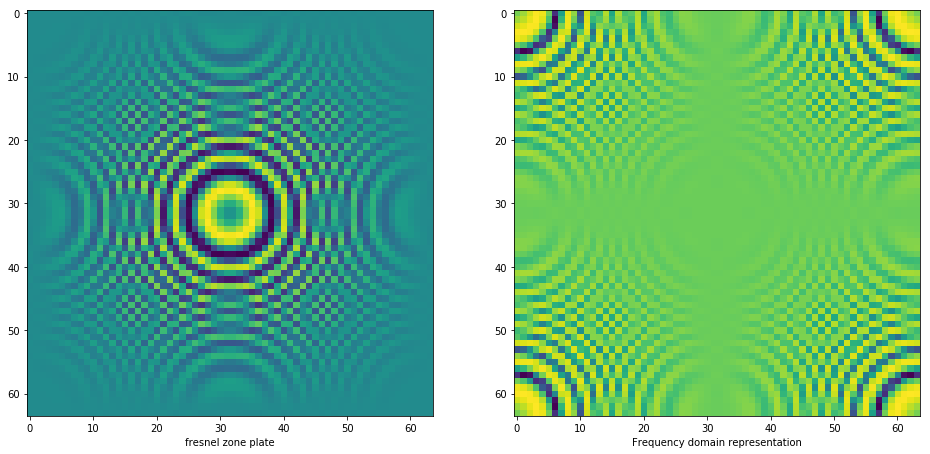

In [18]:
img = AA
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img, interpolation='nearest')
ax[0].set_xlabel('fresnel zone plate')
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(img))), interpolation='nearest')
ax[1].set_xlabel('Frequency domain representation');

### Slicing without filter

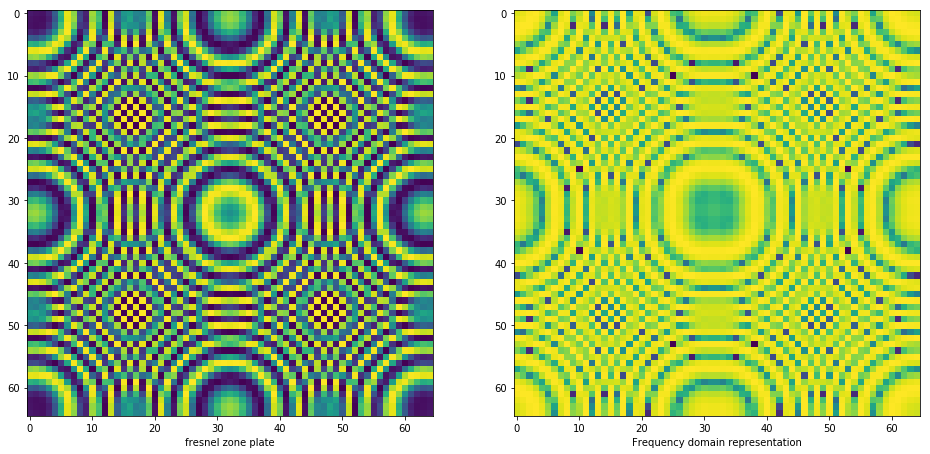

In [19]:
img = res
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img, interpolation='nearest')
ax[0].set_xlabel('fresnel zone plate')
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(img))), interpolation='nearest')
ax[1].set_xlabel('Frequency domain representation');

### Scipy resize

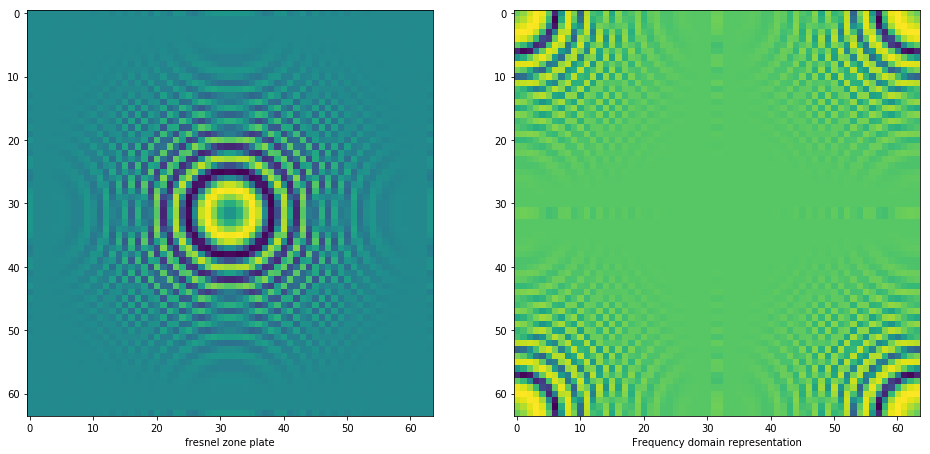

In [22]:
img = out.astype(int)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img, interpolation='nearest')
ax[0].set_xlabel('fresnel zone plate')
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(img))), interpolation='nearest')
ax[1].set_xlabel('Frequency domain representation');